In [51]:
import requests
from bs4 import BeautifulSoup
import spacy
import pandas as pd 
import math
import numpy as np

In [2]:
estados = ["Edomex", "CDMX", "Jalisco", "Veracruz", "Puebla", "Guanajuato", "NuevoLeon", "Chiapas", "Michoacan", "Oaxaca", "BajaCalifornia", "BajaCaliforniaSur", "Chihuahua", "Coahuila", "Durango", "Sinaloa", "Sonora", "Tamaulipas"]

In [3]:
#get the links for each state, and stores them on the dict links_estados
links_estados = {}

for estado in estados:
    filename = "links" + estado + ".txt"

    with open(filename, "r", encoding="utf-8") as f:
        links_estados[estado] = f.readlines()
    

In [5]:
headers = {}
# Use realistic browser headers
browser_headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

for estado in links_estados:
    headers_estado = []
    for url in links_estados[estado]:
        url = url.strip()

        try:
            response = requests.get(url, headers = browser_headers, timeout = 300)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "lxml")

            # Try <title> first
            title_tag = soup.find("title")
            if title_tag and title_tag.get_text(strip = True):
                title = title_tag.get_text(strip = True)
            else:
                # Fallback: Try Open Graph title
                og_title = soup.find("meta", property = "og:title")
                if og_title and og_title.get("content"):
                    title = og_title["content"].strip()
                else:
                    print(f"No title found for {url}")
                    title = "No title found"

            headers_estado.append(title)

        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error for {url}: {http_err}")
        except requests.exceptions.RequestException as req_err:
            print(f"Request failed for {url}: {req_err}")
        except Exception as e:
            print(f"Unexpected error for {url}: {e}")

    headers[estado] = headers_estado

HTTP error for https://imagendelgolfo.mx/veracruz/cruz-roja-cierra-dos-bases-en-veracruz-por-pandemia-de-covid-19/50007667: 404 Client Error: Not Found for url: https://imagendelgolfo.mx/veracruz/cruz-roja-cierra-dos-bases-en-veracruz-por-pandemia-de-covid-19/50007667
HTTP error for https://imagendelgolfo.mx/veracruz/imss-71-de-veracruz-celebra-dar-de-alta-a-tres-pacientes-con-covid-19/50011801: 404 Client Error: Not Found for url: https://imagendelgolfo.mx/veracruz/imss-71-de-veracruz-celebra-dar-de-alta-a-tres-pacientes-con-covid-19/50011801
HTTP error for https://imagendelgolfo.mx/veracruz/neumologos-exhortan-a-tomar-precauciones-tras-deteccion-de-coronavirus-en-veracruz/50002719: 404 Client Error: Not Found for url: https://imagendelgolfo.mx/veracruz/neumologos-exhortan-a-tomar-precauciones-tras-deteccion-de-coronavirus-en-veracruz/50002719
HTTP error for https://imagendelgolfo.mx/xalapa/contempla-imss-2-hospitales-de-veracruz-para-escenario-3/50005678: 404 Client Error: Not Found 

In [ ]:
#Esta parte del código fue para contar y clasificar los errores para poder resolverlos
k_errores = {}
k_errores["Error 404"] = 0
k_errores["Bad Request"] = 0
k_errores["403 Forbidden"] = 0

for head in headers:
    print(head)
    errors = 0

    c = 1

    for l in headers[head]:
        if "Error 404" in l or "Bad Request" in l or "403 Forbidden" in l:
            if "Error 404" in l:
                k_errores['Error 404'] += 1
            if "Bad Request" in l:
                k_errores['Bad Request'] += 1
            if "403 Forbidden" in l:
                k_errores['403 Forbidden'] += 1

            errors += 1
        
        print(c, l)
        c += 1

    print(head, errors, "errores")
    print("-----------------------------------------------------------------")

for i in k_errores:
    print(i, k_errores[i])

In [ ]:
#creamos todos los archivos para guardar la información de los headers
#Sólo se corre una vez

file_names = []

for estado in estados:
    name = "headers" + estado + ".txt"
    file_names.append(name)
    with open(name, "w", encoding="utf-8") as f:
        for head in headers[estado]:
            f.write(head + "\n")

In [3]:
#después de terminar de limpiar manualmente los datos, actualizamos las variables
#Consideramos que la información está en los archivos, ya sin correr el scraping
#Volvemos a declarar el diccionario de headers, para manipular los datos más fácil

#to have the headers info on a map, easier to work with
headers = {}
for estado in estados:
    filename = "headers" + estado + ".txt"

    with open(filename, "r", encoding="utf-8") as f:
        headers[estado] = f.readlines()

In [21]:
#Función para lemmatizar y stemmizar las palabras de los headers
import spacy
from nltk.stem.snowball import SpanishStemmer

nlp = spacy.load("es_core_news_sm")
stemmer = SpanishStemmer()
rollback = {}

def lemmatize_and_stem(text, remove_stopwords = True):
    doc = nlp(text)
    result = []

    for token in doc:
        if token.is_punct or token.is_space:
            continue

        if remove_stopwords and token.is_stop:
            continue

        lemma = token.lemma_.lower()
        stem = stemmer.stem(lemma)

        if stem not in rollback:
            rollback[stem] = set()

        rollback[stem].add(lemma)

        result.append(stem)

    return result


In [60]:
d = []
for i in range(0, 18):
    d.append({})

palabras_estado = dict(zip(estados, d)) #Diccionario para almacenar la recuencia de cada palabra por estado
cant_palabras = {}

nlp = spacy.load("es_core_news_sm")
for estado in estados:
    cant_palabras[estado] = 0

    for header in headers[estado]:
        lmm_hedaer = lemmatize_and_stem(header.lower())

        for l in lmm_hedaer:
            if l.isdigit():
                if l in rollback:
                    rollback.pop(l)
                continue  # Evitar los dígitos, ya que no son palabras

            if l not in palabras_estado[estado]:
                palabras_estado[estado][l] = 1
            else:
                palabras_estado[estado][l] += 1
            cant_palabras[estado] += 1

    #Se ordenan las palabras más frecuentes por estado
    palabras_estado[estado] = dict(sorted(palabras_estado[estado].items(), key=lambda x: x[1], reverse=True))  


In [ ]:
ll_word = ""
ll_size = 0

for i in rollback:
    if len(rollback[i]) > ll_size:
        ll_size = len(rollback[i])
        ll_word = i
    
print(ll_word, rollback[ll_word])
#maybe further analysis

inform {'información', 'informativo', 'informar', 'informe', 'informacion'}


In [20]:
#creamos todos los archivos para guardar la información de los headers
#Sólo se corre una vez
for estado in estados:
    name = "palabras" + estado + ".txt"
    with open(name, "w", encoding="utf-8") as f:
        for palabra in palabras_estado[estado]:
            f.write(palabra + "," + str(palabras_estado[estado][palabra]) + '\n')

In [29]:
#Para análisis globales, un diccionario de frecuencias de todas las palabras
all_words = dict()
for estado in estados:
    for k in palabras_estado[estado]:
        if k not in all_words:
            all_words[k] = 0
        
        all_words[k] += palabras_estado[estado][k]


#ordenar las palabras más frecuentes
all_words_sorted = dict(sorted(all_words.items(), key=lambda x: x[1], reverse=True))  # By value, descending

for l in all_words_sorted:
    print(l, all_words_sorted[l])


covid-19 686
coronavirus 471
cas 210
pandemi 140
mexic 139
cerr 124
hospital 116
med 78
suspend 76
salud 76
san 75
contingent 69
ped 61
puebl 61
medic 60
cov 53
contagi 52
imss 52
cuarenten 51
cdmx 48
sanitari 48
abril 43
atend 42
map 41
confirm 39
public 39
mil 38
trabaj 38
pacient 36
emergent 36
crisis 35
pes 34
apoy 33
sant 32
personal 32
merc 32
leon 32
muert 31
centr 30
edomex 29
posit 29
econom 29
activ 28
municipi 27
oms 27
luis 27
penal 25
evit 25
aument 24
general 24
fas 24
rio 24
oaxac 24
covid19 23
amlo 23
seman 23
sinalo 23
call 22
atencion 22
baj 22
report 21
servici 21
distanci 21
coronaviru 21
michoacan 21
chihuahu 21
coahuil 21
toluc 20
person 20
mexican 20
sum 20
registr 20
famili 20
paz 20
ofrec 20
priv 20
viv 20
enfrent 20
transport 20
sal 20
año 20
inici 20
unid 20
vide 20
segu 20
saltill 20
vall 19
aplic 19
notici 19
emple 19
gobern 19
tiemp 19
color 19
cierr 19
cancel 19
gobiern 19
cubreboc 19
guadalaj 19
don 19
dej 18
tom 18
instal 18
agu 18
culiacan 18
falt 17
l

In [ ]:
print(len(all_words))

3081


In [ ]:
#words that appear in all states, just for curiosity
common_words = set()

for word in all_words:
    isCommon = True

    for estado in estados:
        if word not in palabras_estado[estado]:
            isCommon = False
            break

    if isCommon == True:
        common_words.add(word)

for word in common_words:
    print(word)

contingent
coronavirus
med
covid-19
cerr
cas
hospital
trabaj
suspend
pandemi
medic


In [32]:
def tf_idf (freq_local_doc, words_doc, total_docs, frec_global_docs):
    tf = freq_local_doc / words_doc
    idf =  math.log(total_docs / (1 + frec_global_docs))

    return tf * idf

In [68]:
#TF-IDF index to get the most relevant words

total_docs = len(estados)
most_relevant_words = set()
relevant_words_states = {}
tolerance = 5

for estado in estados:
    weigthed_words = {}

    for word in palabras_estado[estado]:
        freq_local_doc = palabras_estado[estado][word]
        words_doc = len(palabras_estado[estado])
        freq_global_docs = all_words[word]

        weigthed_words[word] = tf_idf(freq_local_doc, words_doc, total_docs, freq_global_docs)

    weigthed_words_sorted = dict(sorted(weigthed_words.items(), key = lambda x: x[1], reverse=True))

    i = tolerance
    relevant_words_states[estado] = set()
    
    for word in weigthed_words_sorted:
        relevant_words_states[estado].add(word)
        i -= 1

        if i == 0:
            break

    most_relevant_words = most_relevant_words | relevant_words_states[estado]

#now we have the 500 most relevant words


In [53]:
#code to get the total cases and population on the date window
window_start = '15-03-2020'
window_end = '30-04-2020'

df = pd.read_csv("Casos_Diarios_Estado_Nacional_Confirmados_20230625.csv")
df_window = df.loc[:, window_start : window_end]
df_window["total_cases"] = df_window.sum(axis = 1)
state_names = (df['nombre'].str.strip().str.lower().str.title().str.replace(' ', '', regex = False).tolist())
df_window['nombres'] = state_names

df_window['nombres'] = df_window['nombres'].replace('DistritoFederal', 'CDMX')
df_window['nombres'] = df_window['nombres'].replace('Mexico', 'Edomex')

df_window["poblacion"] = df["poblacion"]
df_window["percentage"] = df_window["total_cases"] * 100 / df_window["poblacion"]
df_window.set_index("nombres", inplace = True)
df_window

,15-03-2020,16-03-2020,17-03-2020,18-03-2020,19-03-2020,20-03-2020,21-03-2020,22-03-2020,23-03-2020,24-03-2020,...,24-04-2020,25-04-2020,26-04-2020,27-04-2020,28-04-2020,29-04-2020,30-04-2020,total_cases,poblacion,percentage
nombres,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,0,0,1,3,1,2,1,1,4,0,...,11,1,7,18,32,18,27,314,1434635,0.021887
BajaCalifornia,0,2,3,4,5,6,3,2,10,9,...,107,71,78,124,114,121,95,2597,3634868,0.071447
BajaCaliforniaSur,0,0,0,1,0,1,1,0,4,2,...,13,5,7,10,4,4,14,354,804708,0.043991
Campeche,0,0,0,0,0,0,0,0,1,0,...,4,7,9,9,7,9,8,131,1000617,0.013092
Chiapas,0,0,0,1,0,0,0,0,3,0,...,13,9,12,20,10,19,14,235,5730367,0.004101
Chihuahua,0,0,0,1,2,3,2,3,0,1,...,67,51,39,74,70,78,83,1143,3801487,0.030067
CDMX,10,28,35,31,64,36,22,16,46,62,...,571,312,283,550,619,655,609,9490,9018645,0.105226
Coahuila,1,2,2,2,3,4,0,0,3,6,...,16,6,5,25,20,14,20,520,3218720,0.016155
Colima,0,1,0,0,0,0,0,0,0,1,...,3,1,0,2,0,0,3,32,785153,0.004076


In [54]:
#Datos de COVID en cada estado, del 15 de marzo al 30 de abril de 2020
percentage_infected = {
    estado: df_window.loc[estado, 'percentage']
    for estado in estados
    if estado in df_window.index
}

In [64]:
#normalize the word frequency
d = []
for i in range(0, 18):
    d.append({})

norm_palabras_estado = dict(zip(estados, d)) 

for estado in estados : 
    for word in palabras_estado[estado]:
        norm_palabras_estado[estado][word] = palabras_estado[estado][word] / cant_palabras[estado]


In [ ]:
#jane
y = np.array([percentage_infected[estado] for estado in estados])

X = pd.DataFrame(index = estados, columns = list(most_relevant_words)).fillna(0)

for estado in estados:
    for word in most_relevant_words:
        X.loc[estado, word] = norm_palabras_estado[estado].get(word, 0)

In [70]:
#We're aplying Ridge Regression, given the small dataset
from sklearn.linear_model import RidgeCV

model = RidgeCV(alphas=[0.1, 1, 10, 100])
model.fit(X, y)

print("R² score:", model.score(X, y))

R² score: 1.8492113432744262e-06


In [74]:
#Now, a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

cv = LeaveOneOut()

y_pred = cross_val_predict(model, X, y, cv=cv)

mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.020001686561490574
Root Mean Squared Error (RMSE): 0.03115085225750249


We can conclude that makin an analysis with statistically most relevant words doesn't really have correlation with the number of COVID cases.
It makes sense, because words can have different meanings depending on the context. So, it would be better to analyze the full headers and score them by emotional level.

In [76]:

from transformers import pipeline

# Usamos el sentiment analysis pipeline del modelo BETO 
#El modelo califica las palabras en una escala del 1-5, donde 1 es muy negativa y 5 es muy positiva
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

d = {i: 0 for i in range(1, 6)}

scores = {}
for estado in estados:
    scores[estado] = d.copy()

total_score_state = {}

for estado in estados:
    total_score = 0
    scored_headers = {}

    results = classifier(headers[estado])
    
    for result in results:
        label = result["label"]
        score = int(label[0])
        scores[estado][score] += 1

        total_score += int(score)
    
    total_score_state[estado] = total_score

    print(estado, "- score:", total_score) #Imprimimos el valor de "sentimiento" total de los estados
    #Mienrtras sea mayor, dado que se considera aproximadamente la misma cantidad de palabras en cada estado, 
    #significa que las palbras fueron más laxas


Device set to use cpu


Edomex - score: 288
CDMX - score: 347
Jalisco - score: 303
Veracruz - score: 83
Puebla - score: 279
Guanajuato - score: 338
NuevoLeon - score: 339
Chiapas - score: 288
Michoacan - score: 314
Oaxaca - score: 285
BajaCalifornia - score: 275
BajaCaliforniaSur - score: 218
Chihuahua - score: 257
Coahuila - score: 260
Durango - score: 337
Sinaloa - score: 283
Sonora - score: 274
Tamaulipas - score: 260


In [86]:
# Creamos un dataframe con la cantidad de palabras con cada clasificación
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores = df_scores[[1, 2, 3, 4, 5]]

df_scores["Casos COVID"] = df_window['total_cases']
df_scores['Poblacion_total'] = df_window['poblacion']
df_scores['Porcentaje_contagiado'] = df_window['percentage']

#Normalize the number of each score

d = {i: 0 for i in range(1, 6)}
norm_scores = {}
for estado in estados:
    norm_scores[estado] = d.copy()

for estado in estados:
    for score in norm_scores[estado]:
        norm_scores[estado][score] = scores[estado][score] * 100 / len(headers[estado])

df_norm_scores = pd.DataFrame.from_dict(norm_scores, orient='index')
df_norm_scores = df_norm_scores[[1, 2, 3, 4, 5]]

df_norm_scores["Casos COVID"] = df_window['total_cases']
df_norm_scores['Poblacion_total'] = df_window['poblacion']
df_norm_scores['Porcentaje_contagiado'] = df_window['percentage']

df_norm_scores_sorted = df_norm_scores.sort_values(by = 'Porcentaje_contagiado', ascending = False)
df_norm_scores_sorted


,1,2,3,4,5,Casos COVID,Poblacion_total,Porcentaje_contagiado
CDMX,43.697479,4.201681,2.521008,15.966387,33.613445,9490,9018645,0.105226
BajaCalifornia,56.410256,3.418803,5.128205,18.803419,16.239316,2597,3634868,0.071447
BajaCaliforniaSur,60.000000,5.000000,7.000000,13.000000,15.000000,354,804708,0.043991
Sinaloa,57.500000,3.333333,6.666667,10.833333,21.666667,1314,3156674,0.041626
Edomex,54.700855,0.854701,5.982906,20.512821,17.948718,6483,17427790,0.037199
Chihuahua,48.421053,2.105263,5.263158,18.947368,25.263158,1143,3801487,0.030067
Coahuila,50.000000,3.000000,2.000000,27.000000,18.000000,520,3218720,0.016155
Tamaulipas,50.000000,3.000000,8.000000,15.000000,24.000000,581,3650602,0.015915
Sonora,60.833333,1.666667,3.333333,16.666667,17.500000,447,3074745,0.014538
Puebla,58.823529,3.361345,2.521008,15.126050,20.168067,933,6604451,0.014127


### Gráficas ###

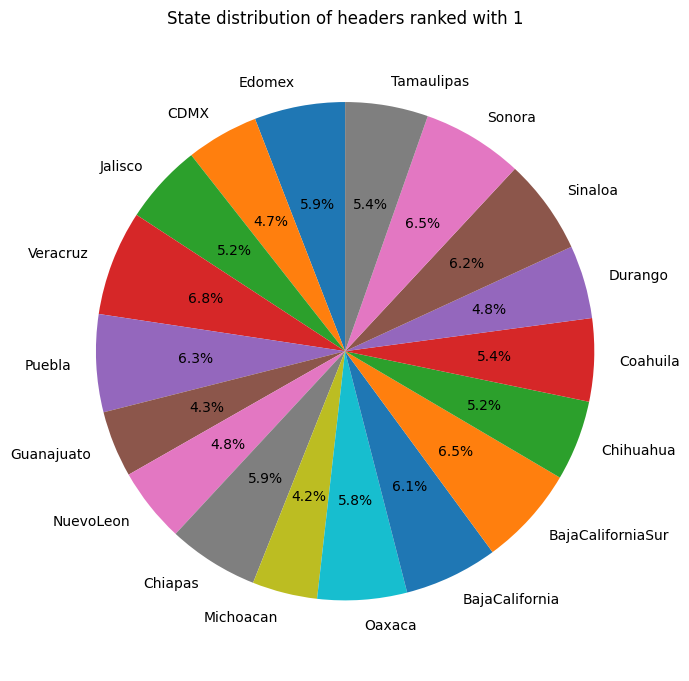

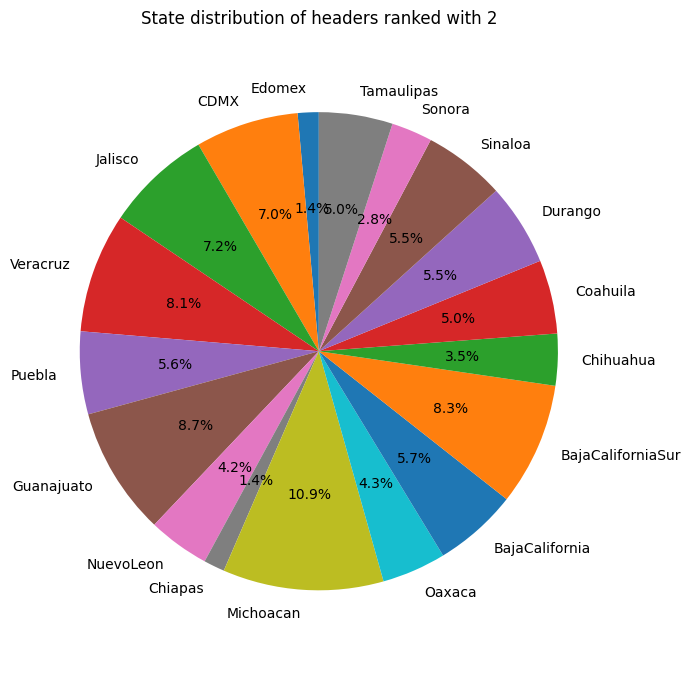

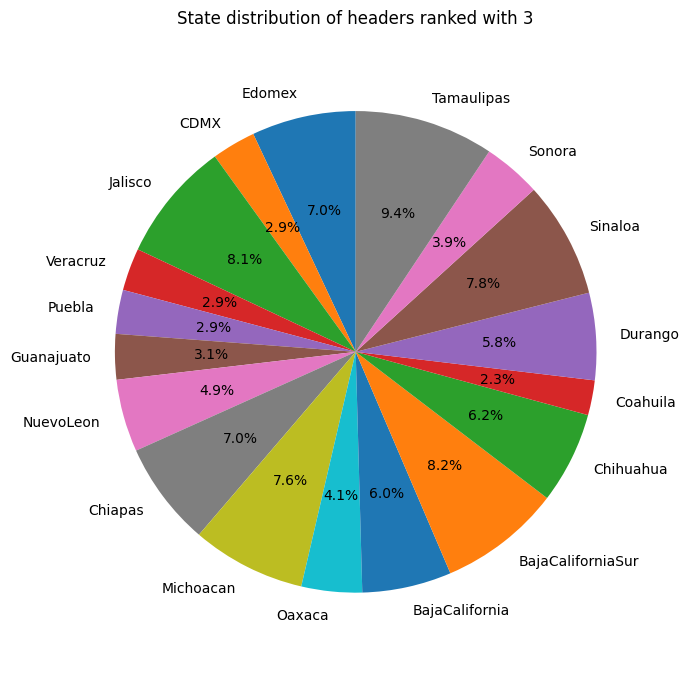

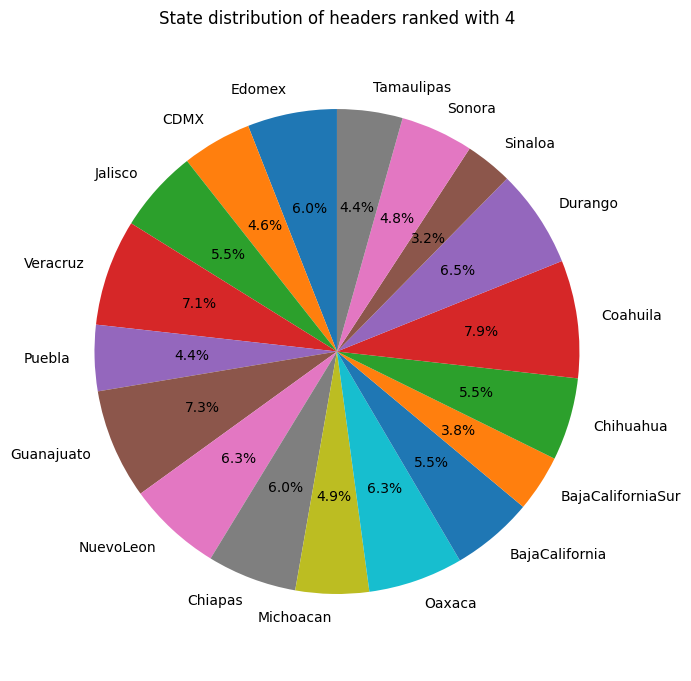

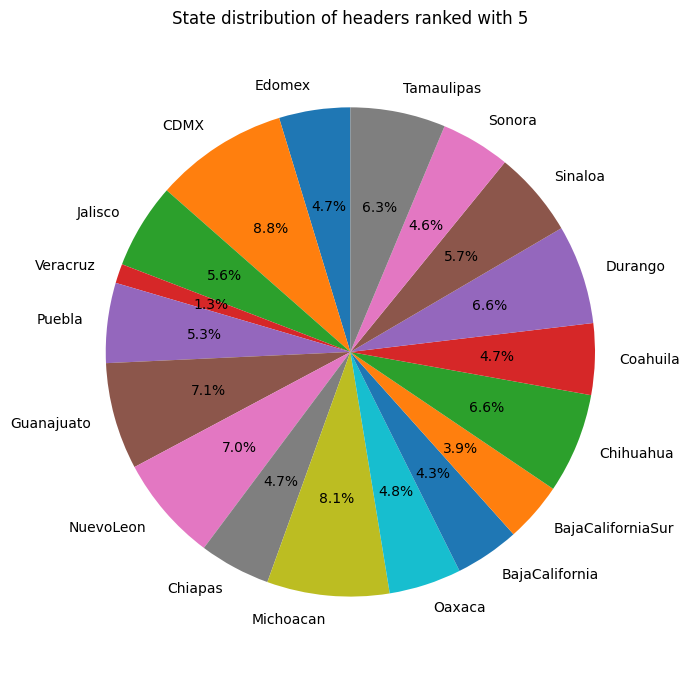

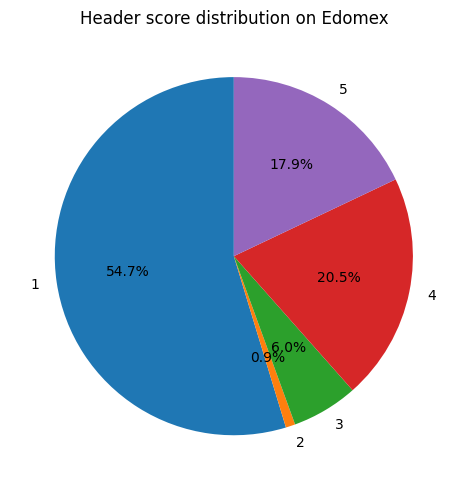

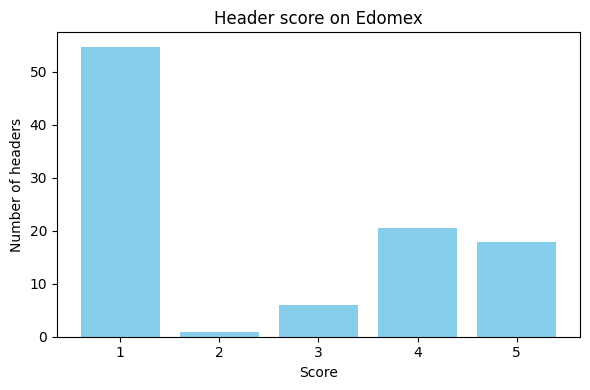

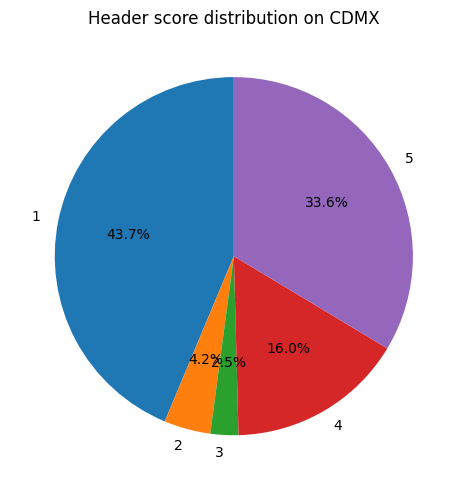

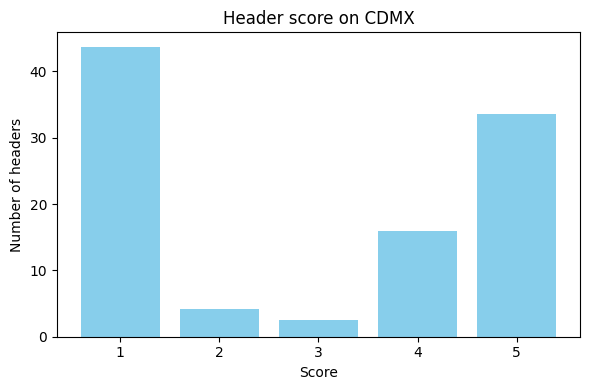

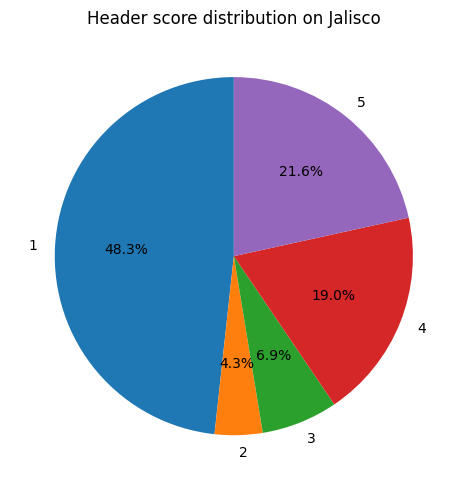

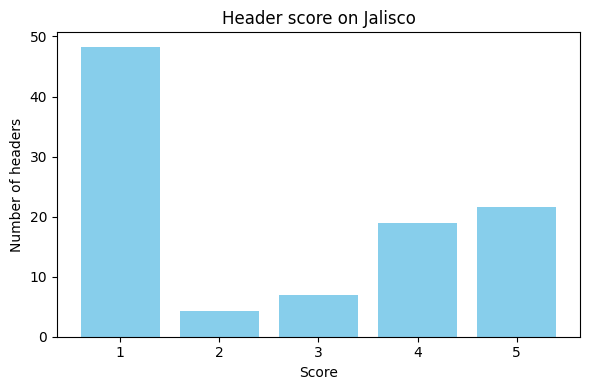

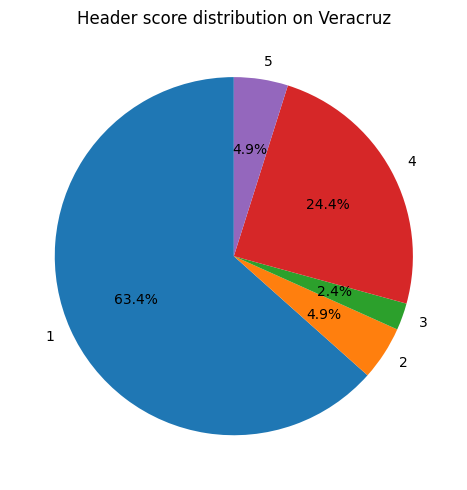

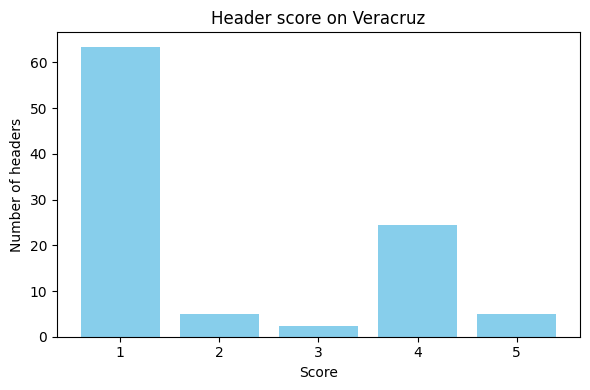

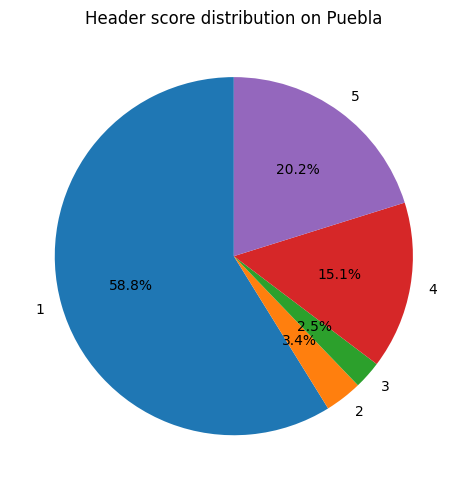

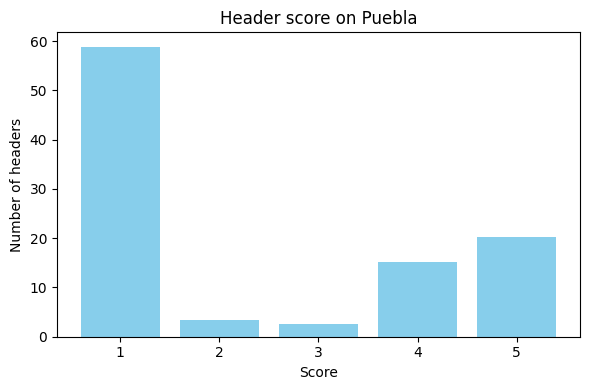

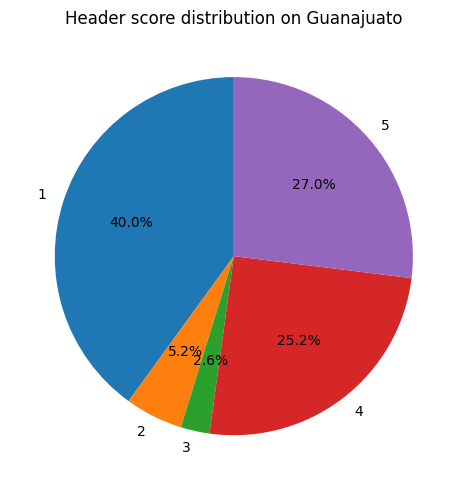

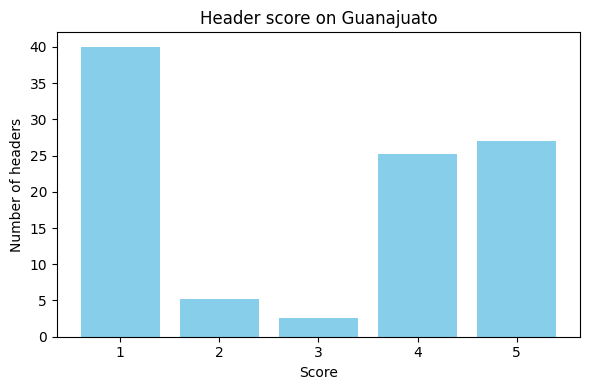

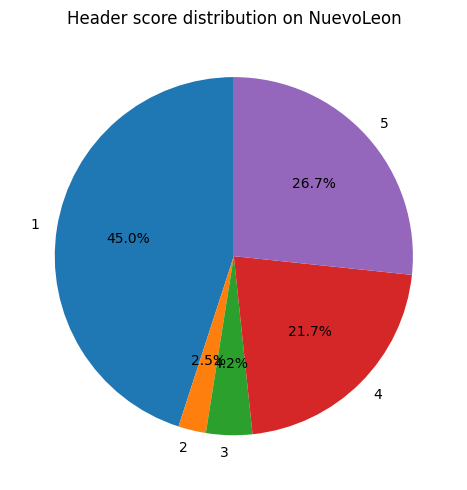

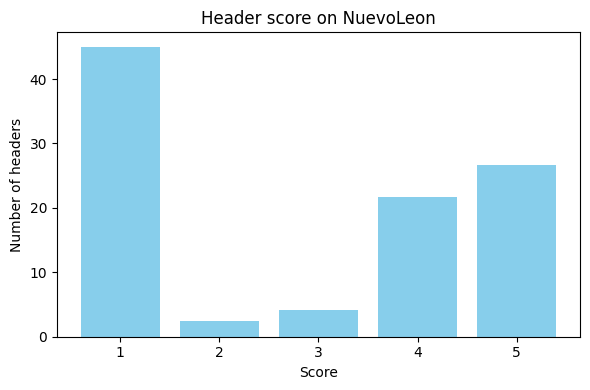

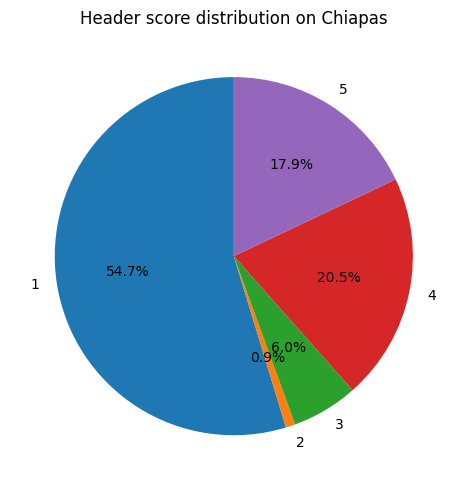

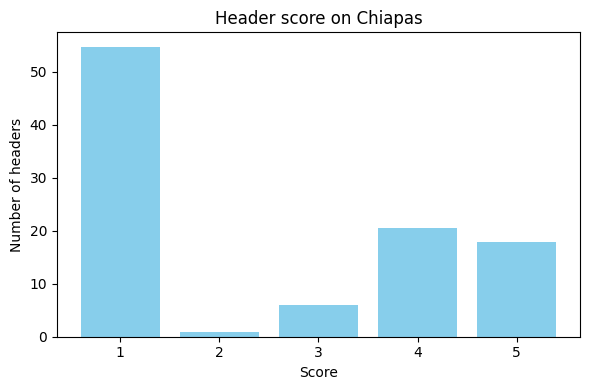

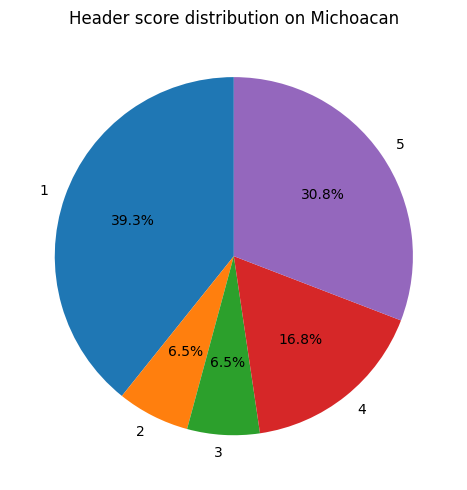

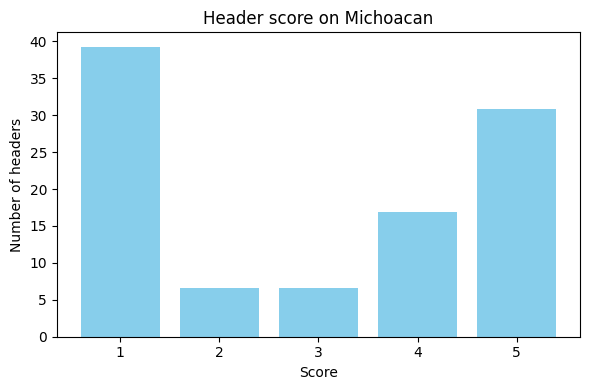

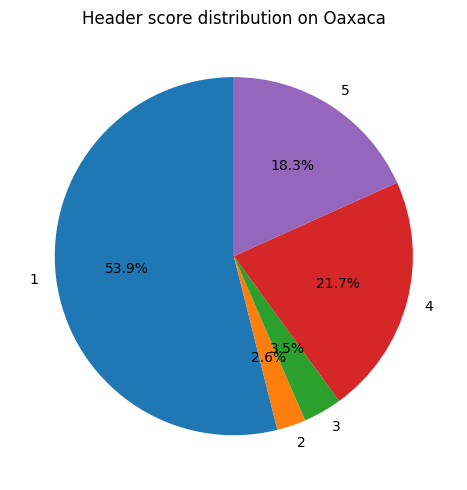

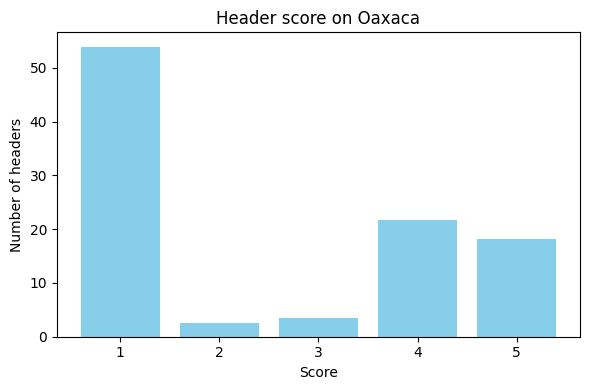

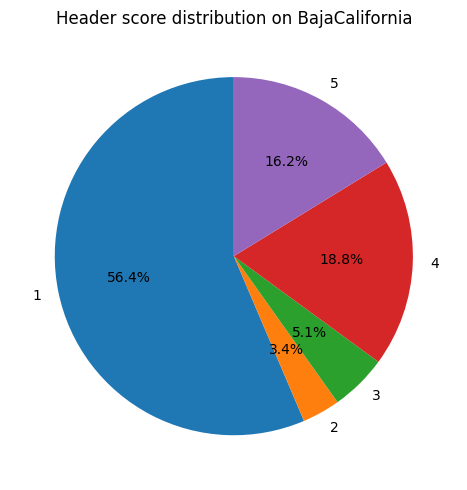

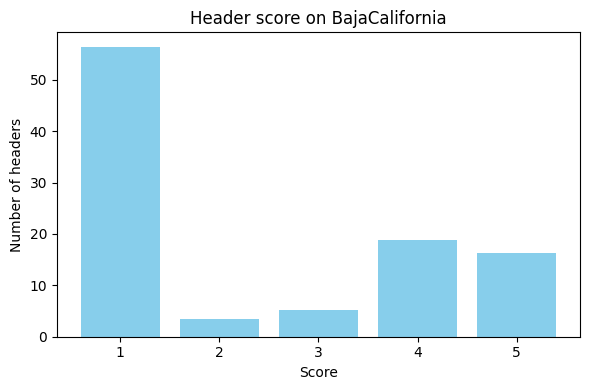

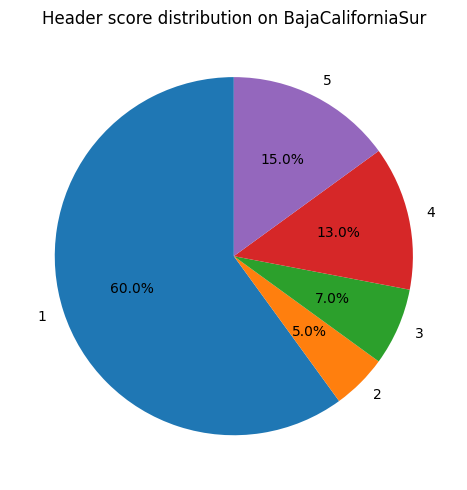

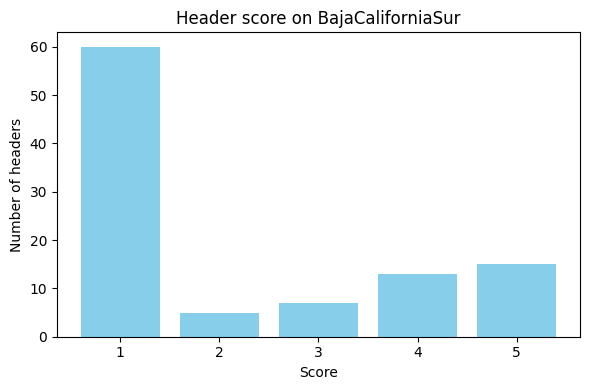

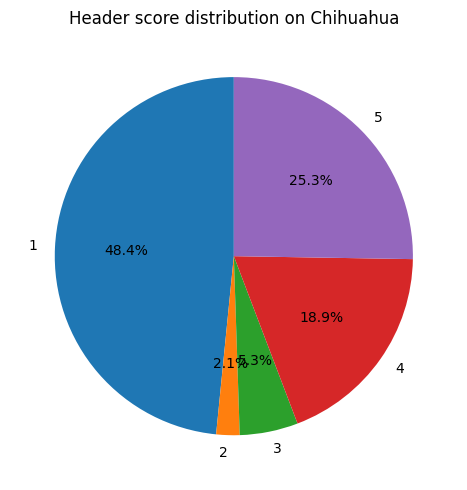

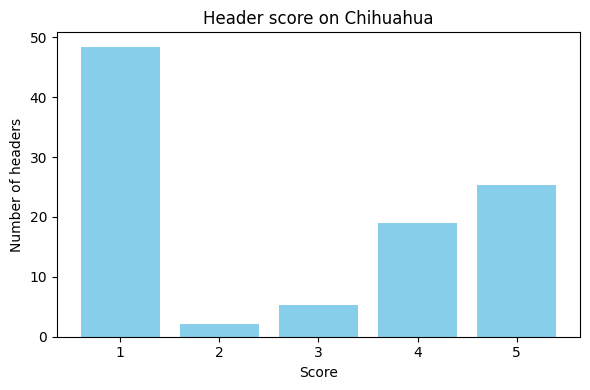

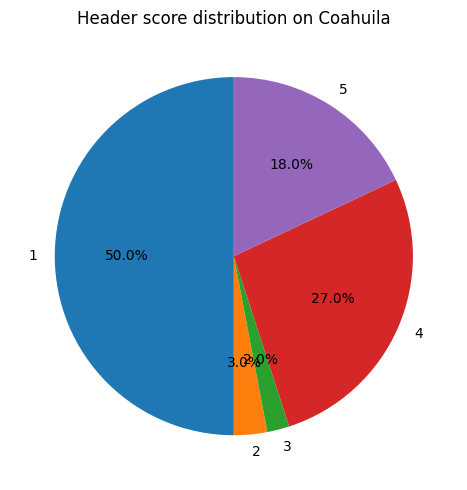

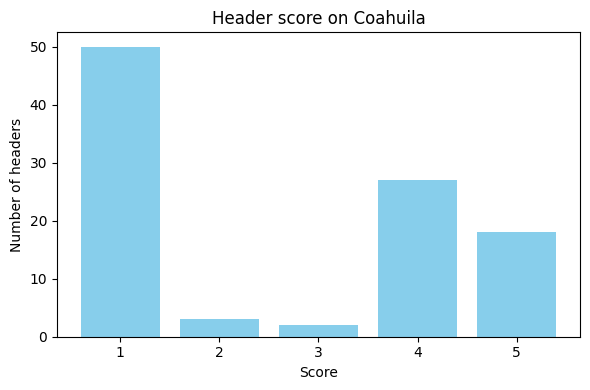

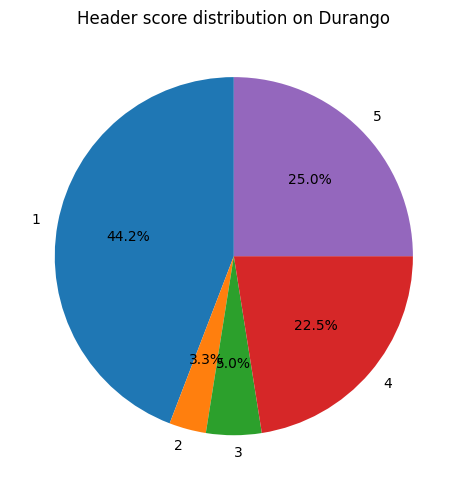

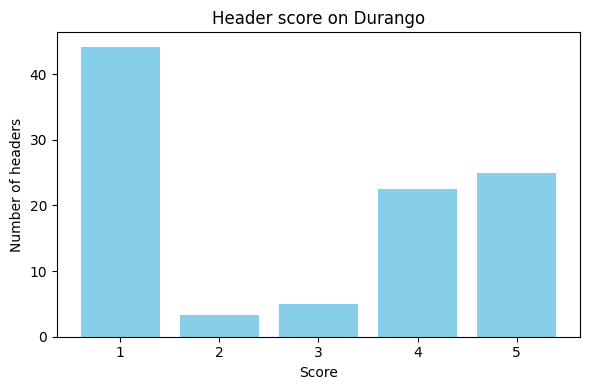

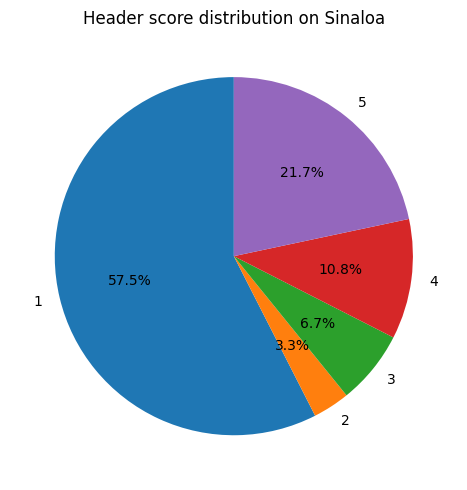

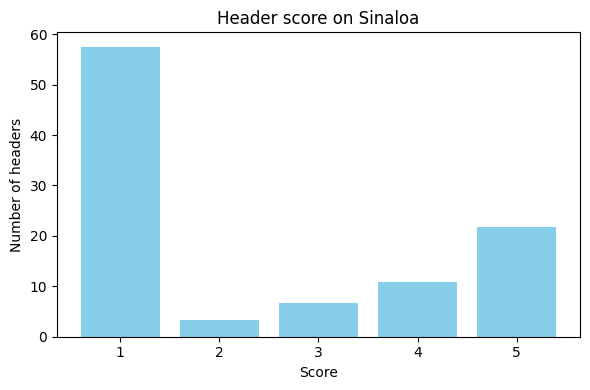

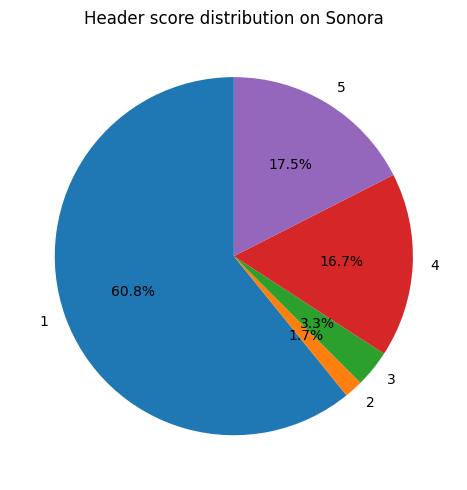

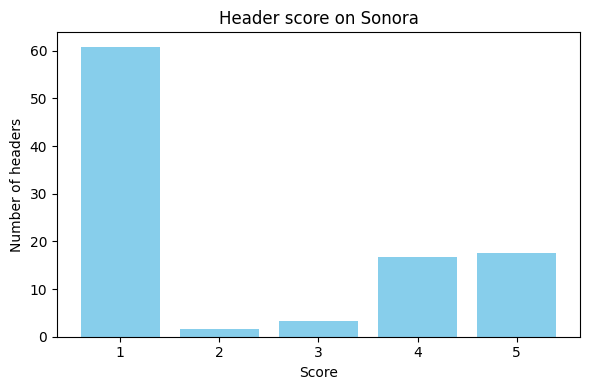

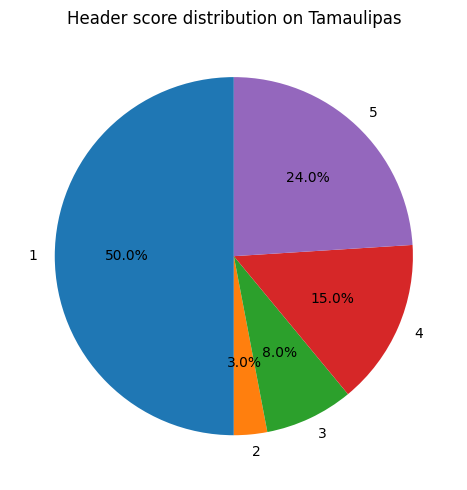

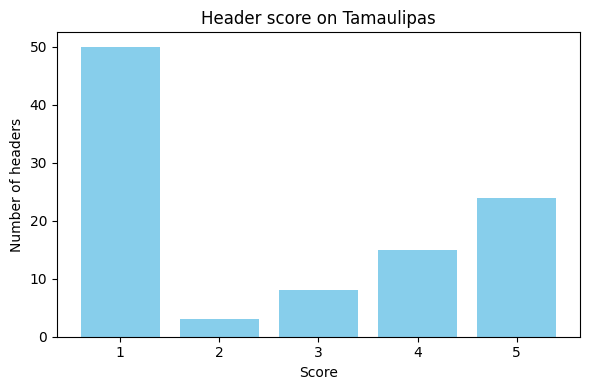

In [87]:
import matplotlib.pyplot as plt

for score in df_norm_scores.columns[:5]:
    sales = df_norm_scores[score]
    plt.figure(figsize=(7, 7))
    plt.pie(sales, labels = df_norm_scores.index, autopct="%1.1f%%", startangle=90)
    plt.title(f"State distribution of headers ranked with {score}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

df_graph = df_norm_scores.iloc[:, :5]

# Loop through each state to create plots
for state in df_graph.index:
    state_scores = df_graph.loc[state]

    plt.figure(figsize=(5, 5))
    plt.pie(state_scores, labels = df_graph.columns, autopct='%1.1f%%', startangle=90)
    plt.title(f"Header score distribution on {state}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.bar(df_graph.columns, state_scores, color='skyblue')
    plt.title(f"Header score on {state}")
    plt.xlabel("Score")
    plt.ylabel("Number of headers")
    plt.tight_layout()
    plt.show()



In [82]:
df_scores_sorted = df_scores.sort_values(by = "Porcentaje_contagiado", ascending=False)
df_scores_sorted


,1,2,3,4,5,Casos COVID,Poblacion_total,Porcentaje_contagiado
CDMX,52,5,3,19,40,9490,9018645,0.105226
BajaCalifornia,66,4,6,22,19,2597,3634868,0.071447
BajaCaliforniaSur,60,5,7,13,15,354,804708,0.043991
Sinaloa,69,4,8,13,26,1314,3156674,0.041626
Edomex,64,1,7,24,21,6483,17427790,0.037199
Chihuahua,46,2,5,18,24,1143,3801487,0.030067
Coahuila,50,3,2,27,18,520,3218720,0.016155
Tamaulipas,50,3,8,15,24,581,3650602,0.015915
Sonora,73,2,4,20,21,447,3074745,0.014538
Puebla,70,4,3,18,24,933,6604451,0.014127


In [96]:
import pandas as pd

data = {}
for state in norm_palabras_estado:
    state_data = {}
    for word in most_relevant_words:
        state_data[word] = norm_palabras_estado[state].get(word, 0)  # get frequency or 0 if missing
    data[state] = state_data

word_freq_df = pd.DataFrame.from_dict(data, orient='index')
word_freq_df["covid_cases"] = pd.Series(percentage_infected)
correlation_matrix = word_freq_df.corr()
word_correlations = correlation_matrix["covid_cases"].drop("covid_cases")
top_correlated_words = word_correlations.abs().sort_values(ascending = False)

print("Palabras más relacionadas con el porcentaje de casos COVID:")

for word, corr in top_correlated_words.head(10).items():
    print(list(rollback[word]))



Palabras más relacionadas con el porcentaje de casos COVID:
['ghost']
['tarjetón']
['ubicar']
['capitalino']
['teatro']
['tijuán', 'tijuana']
['mexicali']
['contrae']
['dólares']
['fauci']


### Modelos de predicción ###

##### Regresión lineal, pero dado que el tamaño de la muestra es pequeño, da una correlación poco verídica #####

R² score: -0.3365493344771606
RMSE: 0.046219125189003


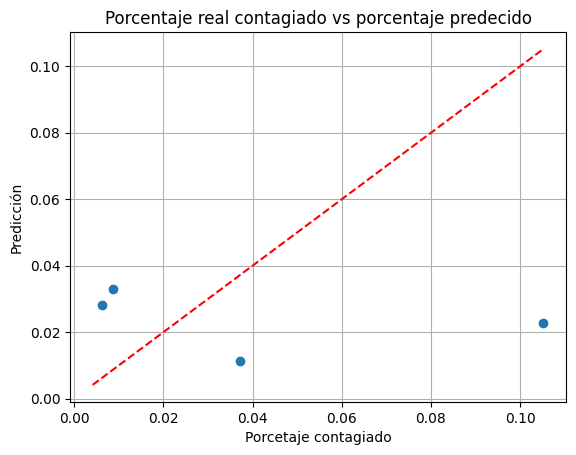

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt

X = df_norm_scores[[2, 5]]
y = df_norm_scores['Porcentaje_contagiado']

# División de la muestra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("R² score:", r2)
print("RMSE:", rmse)

# 7. (Optional) Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Porcetaje contagiado")
plt.ylabel("Predicción")
plt.title("Porcentaje real contagiado vs porcentaje predecido")
plt.grid()
plt.show()

R² score: 0.01419945043835813
RMSE: 0.02623817149278326


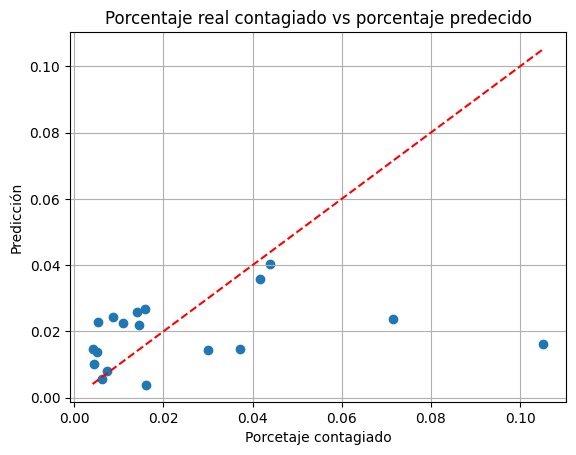

In [104]:

X = df_norm_scores[[1, 2, 3, 4, 5]]
y = df_norm_scores['Porcentaje_contagiado']

# División de la muestra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predict
y_pred = model.predict(X)

# Evaluate
r2 = r2_score(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)

print("R² score:", r2)
print("RMSE:", rmse)

# 7. (Optional) Plot predicted vs actual
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Porcetaje contagiado")
plt.ylabel("Predicción")
plt.title("Porcentaje real contagiado vs porcentaje predecido")
plt.grid()
plt.show()

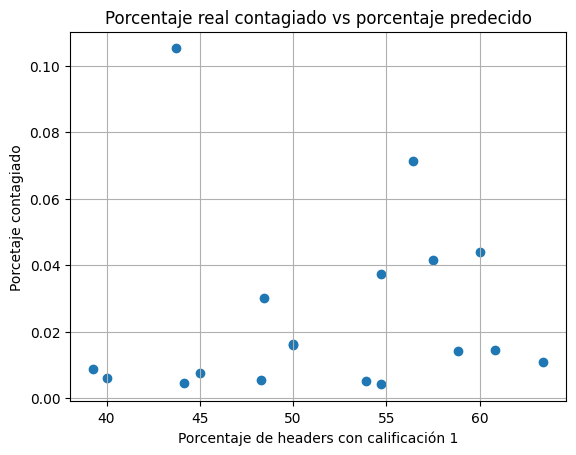

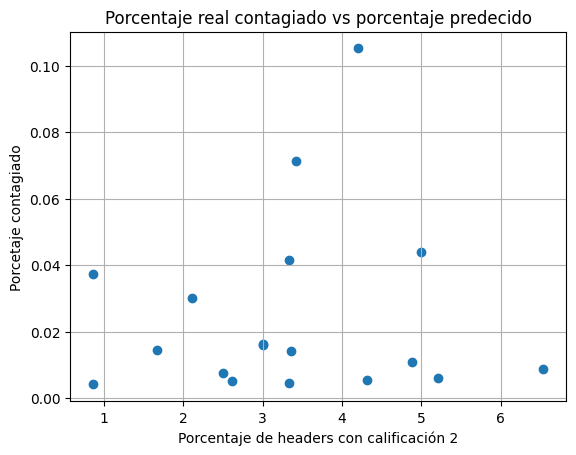

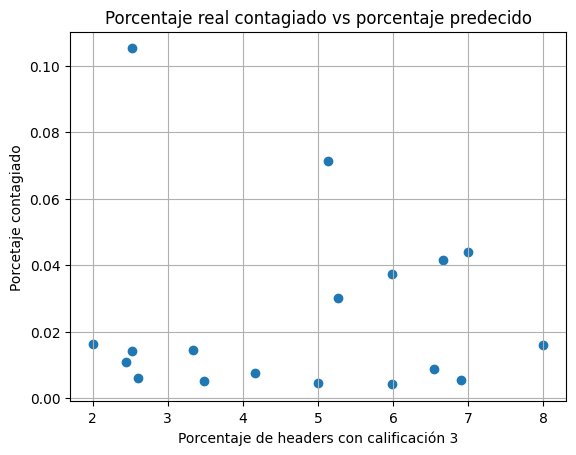

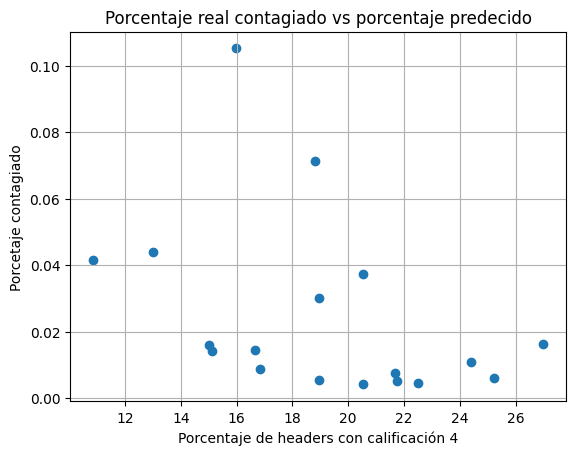

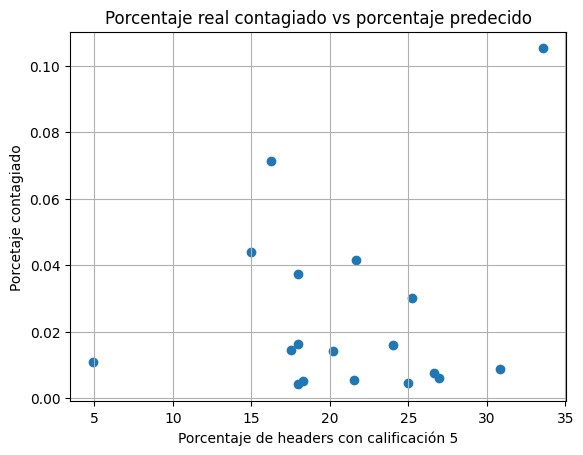

In [113]:
for i in range (1, 6):
    plt.scatter(df_norm_scores[[i]], df_norm_scores['Porcentaje_contagiado'])
    plt.xlabel(f"Porcentaje de headers con calificación {i}")
    plt.ylabel("Porcetaje contagiado")
    plt.title("Porcentaje real contagiado vs porcentaje predecido")
    plt.grid()
    plt.show()

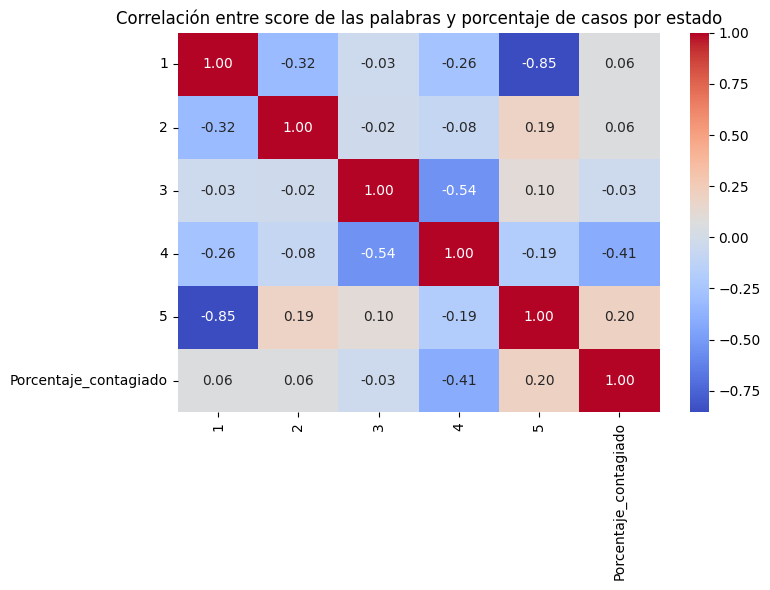

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
corr_df = df_norm_scores_sorted[[1, 2, 3, 4, 5, 'Porcentaje_contagiado']]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Display correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre score de las palabras y porcentaje de casos por estado")
plt.tight_layout()
plt.show()
#hay correlacion entre porcentaje y palabras con score 5

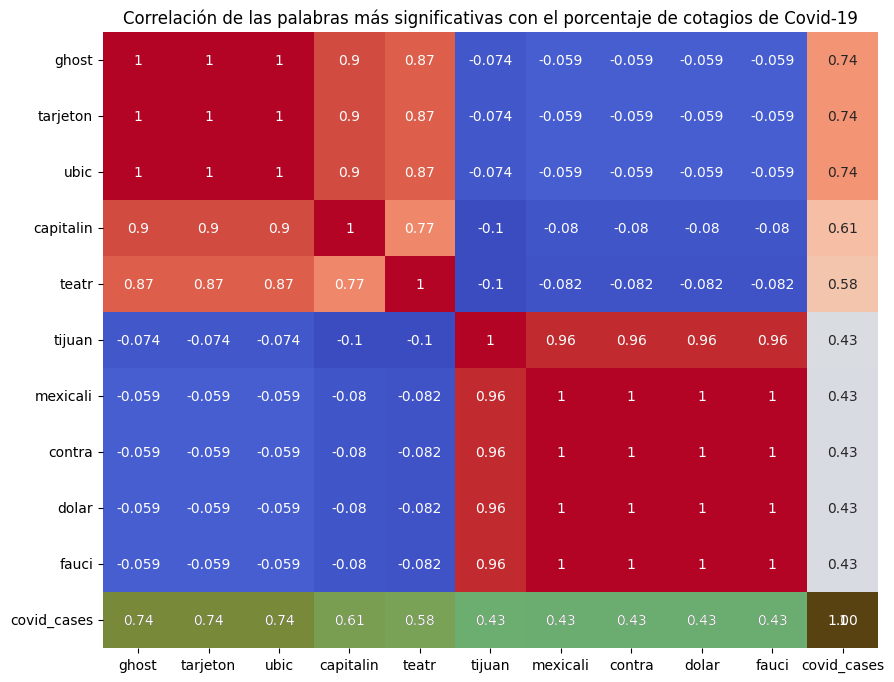

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example heatmap data (you can use your correlation matrix directly)
corr_matrix = word_freq_df[top_correlated_words.head(10).index.tolist() + ["covid_cases"]].corr()

# Create a mask for the whole matrix (False = show, True = hide)
mask = np.zeros_like(corr_matrix, dtype=bool)

# Create a mask where only the last row is False (shown)
mask[:-1, :] = True  # only keep the last row visible

# Plot the heatmap normally
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", cbar=False)

# Overlay the last row in green
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=sns.color_palette(["green"]),
    cbar=False,
    annot_kws={"color": "white"},  # adjust annotation color if needed
    alpha=0.5
)

plt.title("Correlación de las palabras más significativas con el porcentaje de cotagios de Covid-19")
plt.show()


Equation: y ≈ 0.05×Score5 + -0.11×Score6 + -0.36


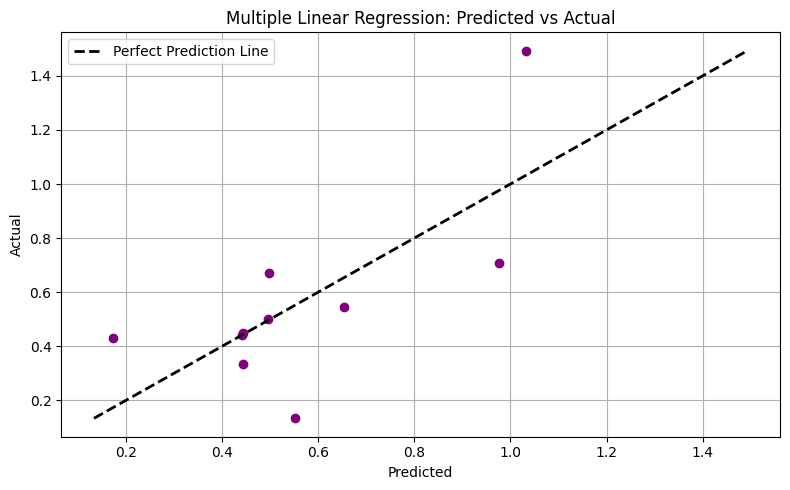

R² score: 0.510
RMSE: 0.241


In [ ]:
#dado que 5 se relaciona con porcentaje y 2 co 5, usamos esos dos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

X_multi = df_scores[[5, 2]] 
y_porcentaje = df_scores['Porcentaje_contagiado']

multi_model = LinearRegression()
multi_model.fit(X_multi, y_porcentaje)

y_pred = multi_model.predict(X_multi)

coefs = multi_model.coef_
intercept = multi_model.intercept_
print(f"Equation: y ≈ {coefs[0]:.2f}×Score5 + {coefs[1]:.2f}×Score6 + {intercept:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_porcentaje, color="purple")
plt.plot([y_porcentaje.min(), y_porcentaje.max()],
         [y_porcentaje.min(), y_porcentaje.max()],
         'k--', lw=2, label="Perfect Prediction Line")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiple Linear Regression: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

r2 = r2_score(y_porcentaje, y_pred)
rmse = root_mean_squared_error(y_porcentaje, y_pred)

print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


##### Obtuvimos un modelo con precisión suficientemente alta para considerar que hay correlación entre la cantidad de palabras positivas y el porcentaje de casos COVID #####